In [109]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')

from pathlib import Path
import pandas as pd
from zipfile import ZipFile
from matplotlib import pyplot as plt
from pns_dict import PNS_DICT
import seaborn as sns
import copy


PNS_DATA = Path('../data/processed/PNS_2019/all.zip').resolve()
zip_pns = ZipFile(PNS_DATA)
df = pd.read_csv(zip_pns.open(zip_pns.namelist()[0]), sep=",", low_memory=False)

PATH_GEN_DATA = Path('generated_data/pns_data_analysis').resolve()

def save_fig(fig_i, name):
    fig_i.savefig(PATH_GEN_DATA / '01_pns_{}.png'.format(name), bbox_inches='tight')
    fig_i.savefig(PATH_GEN_DATA / '01_pns_{}.pdf'.format(name), bbox_inches='tight')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Como é a distribuição de sintomas depressivos por idade

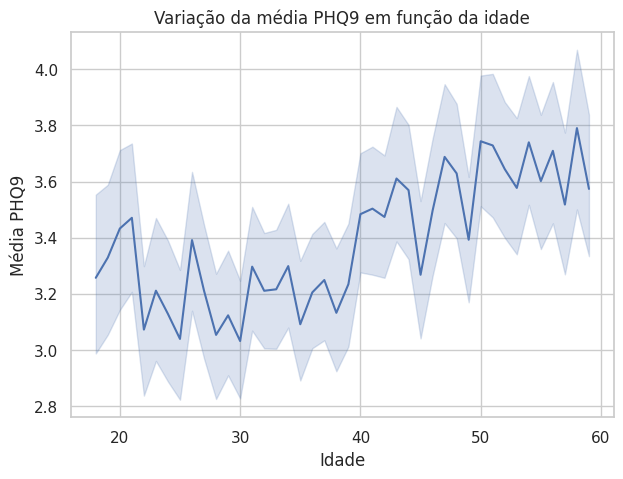

In [110]:
fig, ax = plt.subplots(figsize=(7, 5))

selected = df[['idade', 'phq9_total']]
selected = selected.dropna()
sns.lineplot(data=selected, x="idade", y="phq9_total")
ax.set_ylabel('Média PHQ9')
ax.set_xlabel('Idade')
ax.set_title("Variação da média PHQ9 em função da idade")
save_fig(fig, 'idade_phq9')

/tmp/ipykernel_7434/2740399910.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected['idade'] = df['idade'].apply(categories)


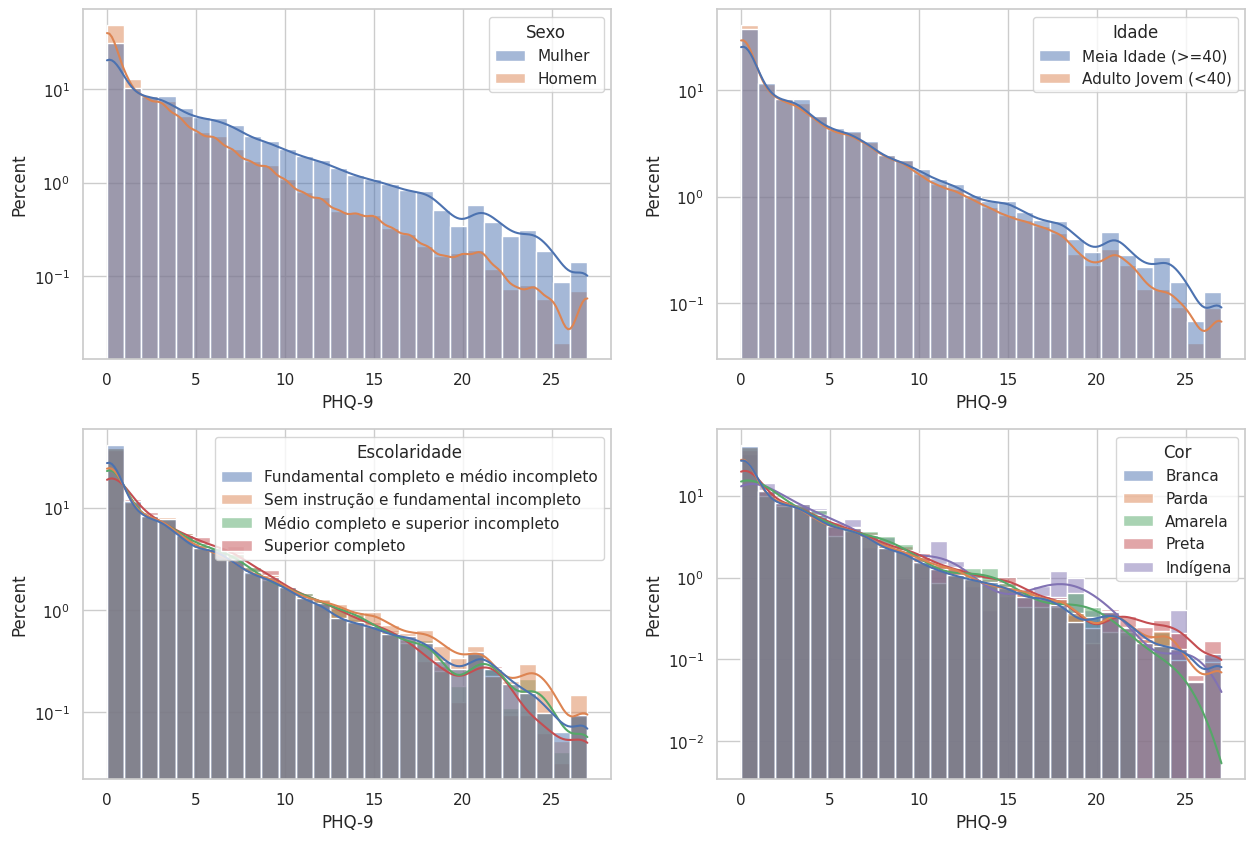

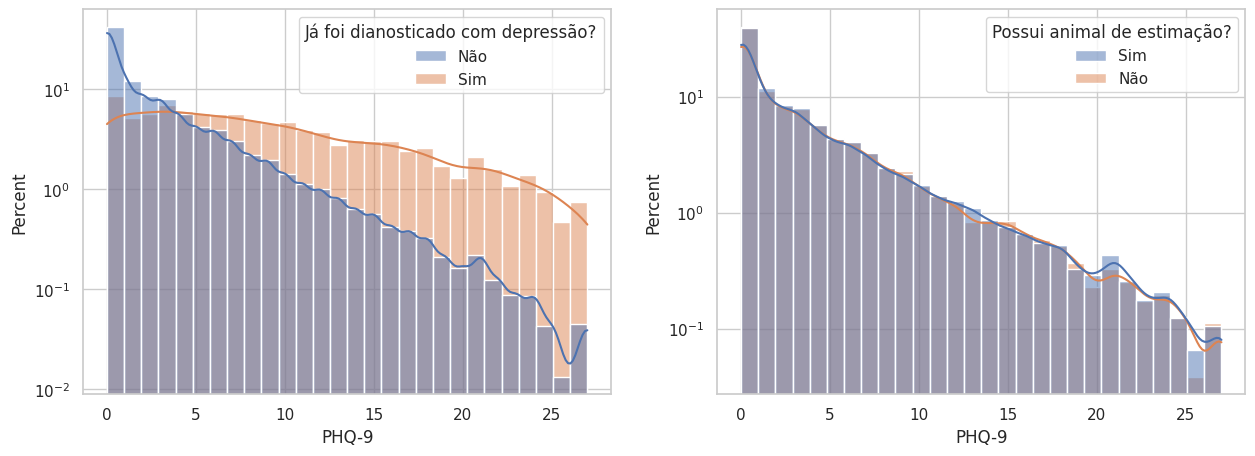

In [111]:
selected = df[['idade', 'sexo', 'cor', 'escolaridade_agregada',  'casa_animal',  'Q092', 'phq9_total']]

def categories(idade):
    if idade < 40:
        return 'Adulto Jovem (<40)'
    else:
        return 'Meia Idade (>=40)'

selected['idade'] = df['idade'].apply(categories)

def plot_dist_phq9(df_i, key, pv, tl, ax):
    df_i = copy.deepcopy(df_i)
    if pv is not None:
        df_i[tl] = df_i[key].map(pv)
    else:
        df_i[tl] = df_i[key]

    ax.set_yscale('log')
    sns.histplot(df_i, hue=tl, x='phq9_total', bins=28, kde=True, ax=ax, stat='percent', label='Sexo', cumulative=False, common_norm=False)
    ax.set_xlabel("PHQ-9")


fig, ax = plt.subplots(2, 2, figsize=(15, 10))
plot_dist_phq9(selected, 'sexo', PNS_DICT.get_pv_dict('sexo'), 'Sexo', ax[0, 0])
plot_dist_phq9(selected, 'idade', None, 'Idade', ax[0, 1])
plot_dist_phq9(selected, 'escolaridade_agregada', PNS_DICT.get_pv_dict('escolaridade_agregada'), 'Escolaridade', ax[1, 0])
plot_dist_phq9(selected[selected['cor']!=9], 'cor', PNS_DICT.get_pv_dict('cor'), 'Cor', ax[1, 1])
plt.show()
save_fig(fig, 'compare_dist_phq9_startos1')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_dist_phq9(selected, 'Q092', PNS_DICT.get_pv_dict('Q092'), 'Já foi dianosticado com depressão?', ax[0])
plot_dist_phq9(selected, 'casa_animal', PNS_DICT.get_pv_dict('casa_animal'), 'Possui animal de estimação?', ax[1])
plt.show()
save_fig(fig, 'compare_dist_phq9_startos2')

In [112]:
from scipy.stats import chi2_contingency

def gen_chi2_statistics(df, columns, test_name):
    selected = df.dropna(subset=['phq9_total'])
    selected['depression_p'] = selected['depression_severity'] > 3

    data = []
    contingency_table = pd.crosstab(selected['casa_animal'], selected['depression_p'])
    chi2, p_value, _, _ = chi2_contingency(contingency_table, correction=False)
    data.append()


